## Global constants

In [1]:
from os import getenv
env = getenv('DATASET_DIR')

NEWSGROUP_HOME = env if env is not None else '../datasets/'

## Necessary imports

In [2]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.corpora.dictionary import Dictionary

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups

## Download 20 newsgroups dataset

In [3]:
train = fetch_20newsgroups(subset='train', data_home=NEWSGROUP_HOME)
test = fetch_20newsgroups(subset='test', data_home=NEWSGROUP_HOME)

In [4]:
print(train['data'][35], sep="\n")

From: dchhabra@stpl.ists.ca (Deepak Chhabra)
Subject: Re: Goalie masks
Nntp-Posting-Host: stpl.ists.ca
Organization: Solar Terresterial Physics Laboratory, ISTS
Lines: 21

In article <120666@netnews.upenn.edu> kkeller@mail.sas.upenn.edu (Keith Keller) writes:
>My vote goes to John Vanbiesbrouck.  His mask has a skyline of New York
>City, and on the sides there are a bunch of bees (Beezer).  It looks
>really sharp.

Funny you should mention this; one time on HNIC Don Cherry pointed out
Vanbiesbrouck's mask.  He _hated_ it.  I think he said something to the effect
of:
"You see?  He was great last year; now he goes out and gets that dopey mask 
and he can't stop a beachball!"

You may or may not take Cherry seriously at all, but I cracked up when I heard
it.

I think Ed Belfour has the current best mask in the NHL btw.  I also like
Moog's, and I'll give Fuhr's new one an honourable mention, although I haven't
seen it closely yet (it looked good from a distance!).  What's also neat is
Chev

## Add additional stopwords

In [5]:
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
stop_list = [
    "subject",
    "from",
    "/",
    "(",
    ")",
    ":",
    "re",
    "nntp",
    "posting",
    "host",
    "lines",
    "write",
    "organization",
    "keyword",
    "distribution",
    "news",
    "software",
    "university",
    "like",
    "think",
    "+",
    "$",
    "s",
    ">",
    "<",
    "C",
    "year",
    "|",
    "=",
    "nt",
    "o",
    "article",
    
]
nlp.Defaults.stop_words.update(stop_list)
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

## Filter out emails and other irrelevant stuff from the texts

In [6]:
def remove_stopwords(doc):
    doc = [token.lemma_ for token in doc
           if not (token.is_stop or
                   token.is_punct or
                   token.like_email or
                   token.like_url or
                   token.is_space or
                   token.like_num or
                   token.lemma_.lower() in stop_list)]
    return doc

nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [7]:
# print(*train['data'][:15])

## Process texts, make a dictionary and a corpus

In [8]:
import re

# doc_lst = []

for i, sent in enumerate(train['data']):
    sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
    sent = re.sub('\s+', ' ', sent)  # remove newline chars
    sent = re.sub("\'", "", sent)  # remove single quotes
    # sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
    # doc_lst.append(sent)
    train['data'][i] = sent

In [9]:
doc_lst = list(nlp.pipe(train['data']))  # Limit number of entries for quicker analysis
dictionary = Dictionary(doc_lst)
corpus = [dictionary.doc2bow(doc) for doc in doc_lst]

In [10]:
print(*doc_lst[:3], sep="\n")

['thing', 'car', 'Maryland', 'College', 'Park', 'wonder', 'enlighten', 'car', 'see', 'day', '2-door', 'sport', 'car', 'look', 'late', '60s/', 'early', '70s', 'call', 'Bricklin', 'door', 'small', 'addition', 'bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'engine', 'spec', 'production', 'car', 'history', 'info', 'funky', 'look', 'car', 'e', 'mail', 'Thanks', 'IL', 'bring', 'neighborhood', 'Lerxst']
['Guy', 'Kuo', 'SI', 'Clock', 'Poll', 'Final', 'Summary', 'Final', 'SI', 'clock', 'report', 'Keywords', 'SI', 'acceleration', 'clock', 'upgrade', 'I.D.', 'shelley.1qvfo9INNc3s', 'Washington', 'fair', 'numb', 'brave', 'soul', 'upgrade', 'SI', 'clock', 'oscillator', 'share', 'experience', 'poll', 'send', 'brief', 'message', 'detail', 'experience', 'procedure', 'speed', 'attain', 'CPU', 'rate', 'speed', 'add', 'card', 'adapter', 'heat', 'sink', 'hour', 'usage', 'day', 'floppy', 'disk', 'functionality', 'be', 'floppy', 'especially', 'request', 'summarize', 'day', 'add', 'network'

## Fit LDA model

In [10]:
# lda_model = LdaModel(corpus=corpus, id2word=dictionary,
#                      num_topics=10, random_state=2,
#                      update_every=, passes=20,
#                      alpha='auto', per_word_topics=True)
lda_model = LdaMulticore(workers=6, corpus=corpus, id2word=dictionary,
                         num_topics=20, random_state=2,
                         per_word_topics=True)

In [11]:
lda_model.print_topics()

[(0,
  '0.005*"people" + 0.004*"X" + 0.004*"know" + 0.003*"right" + 0.003*"time" + 0.003*"have" + 0.003*"way" + 0.003*"say" + 0.003*"go" + 0.003*"thing"'),
 (1,
  '0.006*"have" + 0.004*"know" + 0.003*"be" + 0.003*"well" + 0.003*"use" + 0.003*"people" + 0.003*"time" + 0.003*"try" + 0.003*"get" + 0.003*"say"'),
 (2,
  '0.006*"X" + 0.005*"have" + 0.003*"work" + 0.003*"time" + 0.002*"people" + 0.002*"use" + 0.002*"be" + 0.002*"right" + 0.002*"look" + 0.002*"know"'),
 (3,
  '0.004*"drive" + 0.003*"know" + 0.003*"people" + 0.003*"thing" + 0.003*"way" + 0.003*"have" + 0.003*"use" + 0.003*"need" + 0.003*"look" + 0.003*"time"'),
 (4,
  '0.004*"say" + 0.003*"people" + 0.003*"right" + 0.002*"have" + 0.002*"key" + 0.002*"use" + 0.002*"be" + 0.002*"X" + 0.002*"time" + 0.002*"thing"'),
 (5,
  '0.005*"know" + 0.004*"time" + 0.004*"say" + 0.004*"have" + 0.003*"need" + 0.003*"go" + 0.003*"people" + 0.003*"use" + 0.003*"be" + 0.003*"good"'),
 (6,
  '0.005*"X" + 0.005*"have" + 0.004*"know" + 0.004*"be" +

In [12]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=train['data']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=train['data'])

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)

## Wordcloud visualization

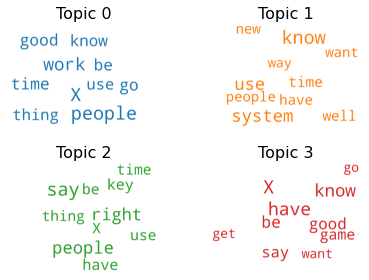

In [15]:
# Something here constantly kills the kernel…
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_list,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud, interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Topic coherence metric value

In [13]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_lst, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5070859123499013